In [1]:
from utils import *
import array 

from pydub import AudioSegment
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, MaxPooling1D,GlobalAveragePooling1D, GlobalMaxPooling1D, UpSampling2D, Lambda, Reshape


from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numba
from keras.callbacks import TensorBoard

import dask.dataframe as dd
from dask.multiprocessing import get

%matplotlib inline

Using TensorFlow backend.


In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

In [3]:
%%time 

train_df = pickle.load( open("cache/train_df_waug.pik","rb"))
valid_df = pickle.load( open("cache/valid_df.pik","rb"))
silent_df = pickle.load(open("cache/silent_df.pik","rb"))
unknown_df = pickle.load(open("cache/unknown_df_waug.pik","rb"))


CPU times: user 12.6 s, sys: 10.1 s, total: 22.7 s
Wall time: 22.7 s


#### loading test data for pseudo labeling

In [4]:
test_df =  pickle.load(open("cache/test_df.pik","rb"))

test_preds = np.load('cache/predictions_mixtimefreq1ds_plus_conv1dlstm_plus_aebased_conv2d_finetuned.npy')


test_df["id"] = test_df.index.values

In [5]:

class MixIterator(object):
    def __init__(self, iters):
        self.iters = iters
        self.multi = type(iters) is list

        self.N = 64 

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def next(self, *args, **kwargs):

        nexts = [next(it) for it in self.iters]
        n0 = np.concatenate([n[0] for n in nexts])
        n1 = np.concatenate([n[1] for n in nexts])
        return (n0, n1)            

In [6]:
#no augmentation since the auto encoder has already seen all the train AND test files 

def train_generator(train_batch_size):
    while True:
        
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        extra_data_size = int(this_train.shape[0]* 0.1)
        this_train = pd.concat([silent_df.sample(extra_data_size),
                                this_train],axis=0 )
#         ,
#                                 unknown_df.sample(extra_data_size*4)
        this_train.reset_index(drop=True,inplace=True)
        
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            y_batch = []
            
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(this_train.loc[i,'raw'].T)
#                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(this_train.label_id.values[i])
                
            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            
            yield x_batch, y_batch
            


In [21]:
np.array([[1,2,3],[4,5,6],[7,8,9]])[::-1,:]

array([[7, 8, 9],
       [4, 5, 6],
       [1, 2, 3]])

In [16]:
unknown_df.reset_index().loc[0,'raw'].T[::-1,:].shape

(32, 128)

In [34]:
def unknown_generator(train_batch_size):
    while True:
        
        this_train = unknown_df.sample(n = int(train_df.shape[0]* 0.4))

        this_train.reset_index(drop=True,inplace=True)
        
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            y_batch = []
            
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                val  = this_train.loc[i,'raw'].T 
                val  = val if np.random.random()<0.5 else val[::-1,:]
                x_batch.append(val)
#                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(this_train.label_id.values[i])
                
            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            
            yield x_batch, y_batch
            

In [35]:
def test_pseudo_generator(test_batch_size):
#     this_test = test_df #.sample(int(train_df.shape[0]//5* 0.1))
#     this_test["id"] = this_test.index.values
    
#     this_test.reset_index(inplace=True)
    while True:

        shuffled_ids = random.sample(range(test_df.shape[0]), test_df.shape[0])

        for start in range(0, len(test_df), test_batch_size):
            x_batch = []
            y_batch = []

            end = min(start + test_batch_size, len(shuffled_ids))
            i_test_batch = shuffled_ids[start:end]

            for i in i_test_batch:
                x_batch.append(test_df.loc[i,'raw'].T)
    #                 x_batch.append(process_wav_file(this_train.iloc[i], augment=True).T)

                y_batch.append(test_preds[test_df.loc[i,'id']])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = np.array(y_batch)

            yield x_batch, y_batch

In [36]:
mi = MixIterator([train_generator(30),unknown_generator(20), test_pseudo_generator(14)])


In [37]:
%time t = next(train_generator(256))[0][0].T

CPU times: user 60 ms, sys: 8 ms, total: 68 ms
Wall time: 69.5 ms


In [38]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [92]:
#a common practice is to choose a filter size in time which spans 2/3 o

In [39]:
timesteps, input_dim , latent_dim = 32,128, 128

input_img = Input(shape=(timesteps, input_dim))  # adapt this if using `channels_first` image data format

x = Reshape((timesteps, input_dim,1))(input_img)

x = Conv2D(64, (10, 10), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same',name='latent_rep')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (10, 10), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded  = Reshape((timesteps, input_dim))(decoded)

autoencoder = Model(input_img, decoded)

In [40]:
autoencoder.load_weights("./weights/starter_ae_wtest_conv_rmse_c6.hdf5")

for l in autoencoder.layers:
    l.trainable = False

In [42]:
p = 0.3

x = BatchNormalization()(autoencoder.get_layer("latent_rep").output)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(p/2)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Dropout(p/2)(x)

x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(p/2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(p/2)(x)

x_max = GlobalMaxPool2D()(x)
x_avg = GlobalAveragePooling2D()(x)

ae_model =  x_max #concatenate([x_max,x_avg])


# x = Dense(128, activation = 'relu')(x)
# x = Dropout(p)(x)

# x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)


In [43]:
def get_conv_stacks( x_in, filter_size=2):
    
    x = BatchNormalization()(x_in)
    x = Conv1D(32,filter_size,activation='relu')(x)
    x = Dropout(p/2)(x)
    x = Conv1D(32,filter_size,activation='relu')(x)
    x = Dropout(p/2)(x)



#     x = LSTM(128,return_sequences=True)(x)

    x = Conv1D(64,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)
    x = Conv1D(64,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)


    
    
    x = BatchNormalization()(x)

#     x = LSTM(128,return_sequences=True)(x)

    x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)    
    x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)
    x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)
    x = Conv1D(128,filter_size,activation='relu',dilation_rate=2)(x)
    x = Dropout(p/2)(x)


    x = BatchNormalization()(x)


    x_max = GlobalMaxPooling1D()(x)
    x_avg = GlobalAveragePooling1D()(x)

    x = concatenate([x_max,x_avg])
    
    return x

In [44]:
def get_1dconvs_maxpool( x_in, filter_size=2):
    
    x = BatchNormalization()(x_in)
    x = Conv1D(64,filter_size,activation='relu',padding='same')(x)
    x = Dropout(p/2)(x)
    x = Conv1D(64,filter_size,activation='relu',padding='same')(x)
    x = Dropout(p/2)(x)
    x = Conv1D(64,filter_size,activation='relu',padding='same')(x)
    x = Dropout(p/2)(x)

    x  = MaxPooling1D()(x)   
    x = BatchNormalization()(x)


    x = Conv1D(128,filter_size,activation='relu',padding='same')(x)
    x = Dropout(p/2)(x)    
    x = Conv1D(128,filter_size,activation='relu',padding='same')(x)
    x = Dropout(p/2)(x)
    x = Conv1D(128,filter_size,activation='relu',padding='same')(x)
    x = Dropout(p/2)(x)
    
    x = BatchNormalization()(x)

    
    
    x_max = GlobalMaxPooling1D()(x)
#     x_avg = GlobalAveragePooling1D()(x)

#     x = concatenate([x_max,x_avg])
    
    return x_max

In [45]:
timesteps, input_dim , latent_dim = 32,128, 128



x_3 = get_1dconvs_maxpool(input_img,10)
x_2 = get_1dconvs_maxpool(input_img,5)
x_1 = get_1dconvs_maxpool(input_img,2)

x = concatenate([x_1,x_2,x_3,
                 ae_model])

#original 
# x_2 = get_conv_stacks(input_img,2)
# x_3 = get_conv_stacks(input_img,3)



# x_freq = Reshape((input_dim, timesteps))(input_img)
# xf_8 = get_conv_stacks(x_freq,8)


# x = concatenate([x_2,x_3,
#                  xf_8,ae_model])



x = Dense(128, activation = 'relu')(x) #
x = Dropout(p)(x)


x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)



In [46]:

model = Model(inputs=[input_img], outputs = x)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [101]:
# p = 0.5

# x_in = Input(shape = (128,32,1)) #1 channel, 99 time, 161 freqs # S : np.ndarray [shape=(n_mels, t)]

# x = BatchNormalization()(x_in)

# x = Conv2D(64, (9,10),activation='relu',padding='same')(x)
# x = Dropout(p)(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((3,2),padding='same')(x)

# x = Conv2D(128, (4,5),activation='relu',padding='same')(x)
# x = Dropout(p)(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((3,2),padding='same')(x)


# x = Conv2D(128, (2,2),activation='relu',padding='same')(x)
# x = Dropout(p)(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D(padding='same')(x)



# x = GlobalMaxPool2D()(x)

# # x = Flatten()(x)
# x = Dense(64, activation = 'relu')(x) #
# x = Dropout(p)(x)

# # x = Dense(64, activation = 'relu')(x)
# # x = Dropout(0.3)(x)

# x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)




# model = Model(inputs = x_in, outputs = x)
# model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
# # model.summary()

Epoch 14/100
300/300 [==============================] - 214s - loss: 0.7612 - acc: 0.7370 - val_loss: 1.0481 - val_acc: 0.6508



Epoch 31/100
350/350 [==============================] - 227s - loss: 0.4294 - acc: 0.8518 - val_loss: 0.9436 - val_acc: 0.7179
Epoch 32/100



Epoch 00058: reducing learning rate to 1.00000006569e-06.
329/329 [==============================] - 191s - loss: 0.7292 - acc: 0.7521 - val_loss: 0.7132 - val_acc: 0.8770


with ae, p=0.
Epoch 28/100
329/329 [==============================] - 7s - loss: 0.3312 - acc: 0.8829 - val_loss: 0.4124 - val_acc: 0.8579

with p=0.4 and /2 for convs 
Epoch 28/100
329/329 [==============================] - 7s - loss: 0.5534 - acc: 0.8056 - val_loss: 0.5074 - val_acc: 0.8312

with p=0.2 and /2
Epoch 00035: reducing learning rate to 1.0000000475e-05.
329/329 [==============================] - 7s - loss: 0.2414 - acc: 0.9137 - val_loss: 0.3686 - val_acc: 0.8811


original aebased p.3
frozen:
Epoch 19/100
989/989 [==============================] - 37s - loss: 0.4131 - acc: 0.8549 - val_loss: 0.3392 - val_acc: 0.8849
with finetuning
Epoch 5/100
989/989 [==============================] - 85s - loss: 0.3845 - acc: 0.8654 - val_loss: 0.3238 - val_acc: 0.8920

increase filter size, less max, more layers (aebase_aug_drp3_frozen_extralayers)
Epoch 10/100
1978/1978 [==============================] - 64s - loss: 0.2238 - acc: 0.9242 - val_loss: 0.2565 - val_acc: 0.9253



-- time and frequency 1dconvs (v1) with frozen ae base (aebase_mix_1dconvs_on_timenfreq_frozen_c2)

Epoch 10/100
1978/1978 [==============================] - 193s - loss: 0.1665 - acc: 0.9453 - val_loss: 0.1689 - val_acc: 0.9511





-- aebase_mix_1dtimeconvswithmaxpool_frozen

Epoch 32/100
395/395 [==============================] - 34s - loss: 0.2949 - acc: 0.9321 - val_loss: 0.1594 - val_acc: 0.9475

finetuned
Epoch 8/100
395/395 [==============================] - 46s - loss: 0.2926 - acc: 0.9302 - val_loss: 0.1564 - val_acc: 0.9501


reverse unknown 
Epoch 36/100
395/395 [==============================] - 34s - loss: 0.2846 - acc: 0.9346 - val_loss: 0.1558 - val_acc: 0.9481

In [48]:
exp_name = "aebase_mix_1dtimeconvswithmaxpool_reverseunknown_frozen"
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-5),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True)]
#              ,      TensorBoard(log_dir='./logs/logs_{}'.format(exp_name), histogram_freq=0, batch_size=64, write_graph=True)]

In [15]:
# model.load_weights('weights/{}.hdf5'.format(exp_name))

In [49]:
batch_size = 64

history = model.fit_generator(generator=mi,#train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1.2/5)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
395/395 [==============================] - 42s - loss: 1.6934 - acc: 0.5021 - val_loss: 1.1513 - val_acc: 0.5755
Epoch 2/100
395/395 [==============================] - 35s - loss: 0.9702 - acc: 0.6893 - val_loss: 0.7820 - val_acc: 0.7380
Epoch 3/100
395/395 [==============================] - 35s - loss: 0.7460 - acc: 0.7734 - val_loss: 0.4675 - val_acc: 0.8540
Epoch 4/100
395/395 [==============================] - 35s - loss: 0.6554 - acc: 0.8094 - val_loss: 0.4192 - val_acc: 0.8616
Epoch 5/100
395/395 [==============================] - 36s - loss: 0.5843 - acc: 0.8325 - val_loss: 0.3895 - val_acc: 0.8834
Epoch 6/100
395/395 [==============================] - 35s - loss: 0.5483 - acc: 0.8476 - val_loss: 0.3620 - val_acc: 0.8834
Epoch 7/100
395/395 [==============================] - 36s - loss: 0.5066 - acc: 0.8614 - val_loss: 0.2906 - val_acc: 0.9032
Epoch 8/100
395/395 [==============================] - 35s - loss: 0.4948 - acc: 0.8652 - val_loss: 0.2901 - val_acc: 0.9078


In [63]:
for l in model.layers:
    l.trainable = True
    
    
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
model.load_weights('./weights/{}.hdf5'.format(exp_name))

In [65]:
exp_name = "aebase_mix_1dtimeconvswithmaxpool_reverseunknown_finetune"
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                              min_lr=1e-5),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True)]

In [66]:
history = model.fit_generator(generator=mi, #train_generator(batch_size),
                              steps_per_epoch=train_df.shape[0]*(1.2/5)//batch_size,
                              epochs=100,
                              callbacks=callbacks,
                              validation_data=valid_generator(batch_size),
                              validation_steps=int(np.ceil(valid_df.shape[0]/batch_size)))

Epoch 1/100
395/395 [==============================] - 50s - loss: 0.2963 - acc: 0.9299 - val_loss: 0.1657 - val_acc: 0.9447
Epoch 2/100
395/395 [==============================] - 48s - loss: 0.2931 - acc: 0.9322 - val_loss: 0.1603 - val_acc: 0.9462
Epoch 3/100
395/395 [==============================] - 47s - loss: 0.2900 - acc: 0.9343 - val_loss: 0.1630 - val_acc: 0.9455
Epoch 4/100
395/395 [==============================] - 47s - loss: 0.2891 - acc: 0.9341 - val_loss: 0.1620 - val_acc: 0.9435
Epoch 5/100
394/395 [============================>.] - ETA: 0s - loss: 0.2944 - acc: 0.9325
Epoch 00004: reducing learning rate to 1e-05.
395/395 [==============================] - 48s - loss: 0.2941 - acc: 0.9326 - val_loss: 0.1601 - val_acc: 0.9491
Epoch 6/100
395/395 [==============================] - 47s - loss: 0.2854 - acc: 0.9356 - val_loss: 0.1585 - val_acc: 0.9488
Epoch 7/100
395/395 [==============================] - 48s - loss: 0.2818 - acc: 0.9363 - val_loss: 0.1571 - val_acc: 0.9491

In [67]:
model.load_weights('./weights/{}.hdf5'.format(exp_name))

### valid evaluation

In [76]:


def augment_wav(wav,pval=0.5):
    sample_rate = 16000
    L = 1000 #16000  # 1 sec
    
    #adjust speed, with 50% chance
#     wav = speed_change(wav,1.+random.uniform(-1, 1)*0.05) if np.random.random() < pval else wav
    
    
    #adjust volume
    db_adjustment = random.uniform(-1, 1)*10
    wav = wav + db_adjustment if np.random.random() < pval else wav
     
        
    #fill to 1 second
    wav = fill_to_1sec(wav)        
        
    #shift the audio by 10 ms
    shift_length = 100
    if np.random.random() < 0.5: #shift to left
        wav = wav[:L-shift_length]+ AudioSegment.silent(shift_length,frame_rate=sample_rate)
    else: #shift to right
        wav = AudioSegment.silent(shift_length,frame_rate=sample_rate) + wav[shift_length:]
        
        
        
    #blend original file with background noise     
    if np.random.random() < pval:
        noise = random.choice(silence_files_AS)
        db_delta = (wav.dBFS - noise.dBFS) -10.

        if db_delta< 0: #reduce intensity of loud background; if it's too silent, leave it be
            noise = noise  + db_delta
        wav = wav.overlay(noise)
 
    return wav



def process_wav_file(record, reshape=False, augment=False,pval=0.5 ,output_format='logmel',n_mels=128 ):
    
    if type(record) == str: # test files
        fname = record
        label = "test"
    else:    
        fname  = record.wav_file
        label = record.label

        
        
        
        
    if "raw_AS_wav" in record: 
        wav = record.raw_AS_wav
    else:
        wav = AudioSegment.from_wav(fname.replace("\\","/"))
        
        
    
    if (not label in ["silence"]) and augment: #no augmentation for sample files 
        wav = augment_wav(wav,pval)

    else: #make sure segment is 1 second
        wav = fill_to_1sec(wav)

        
    samples = AS_to_raw(wav)
    
    
    
    if output_format == "logmel":
        output = log_mel(samples,reshape=reshape,n_mels=n_mels)
        
    elif output_format == "mfcc":
        log_S = log_mel(samples,reshape=False,n_mels=n_mels)
        mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=40) #hirese mfcc
        delta1 = librosa.feature.delta(mfcc, order=1)#hirese mfcc
        delta2 = librosa.feature.delta(mfcc, order=2)

        output = np.stack([mfcc,delta1,delta2])
        
    elif  output_format == "cqt":   
        output = librosa.cqt(samples, sr=16000)
    else:
        output = samples
    
    
    return output


In [85]:
def valid_aug_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            y_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(process_wav_file(valid_df.iloc[i],augment=True).T)
                y_batch.append(valid_df.label_id.values[i])

            x_batch = 1.- np.array(x_batch)/-80.
            y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, y_batch

In [83]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [88]:

silence_files_AS = [AudioSegment.from_wav(x) for x in silent_df.wav_file.values]

filler = AudioSegment.silent(duration=1000, frame_rate = 16000)

In [103]:
val_preds = model.predict_generator(valid_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))


In [91]:
val_preds += model.predict_generator(valid_aug_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))
val_preds += model.predict_generator(valid_aug_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))
val_preds += model.predict_generator(valid_aug_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))
val_preds += model.predict_generator(valid_aug_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))
val_preds += model.predict_generator(valid_aug_generator(64),steps=int(np.ceil(valid_df.shape[0]/64.)))


In [92]:
val_preds/=6.0

In [104]:
val_preds = np.argmax(val_preds,axis=1)

In [105]:
val_preds.shape

(3091,)

In [106]:
oe = OneHotEncoder()

In [107]:
y_true = oe.fit_transform(valid_df.label_id.values.reshape(-1, 1)).todense()



In [108]:
val_preds = oe.transform(val_preds.reshape(-1, 1)).todense()


In [98]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.99      0.94      0.97       261
         no       0.91      0.93      0.92       270
         up       0.91      0.93      0.92       260
       down       0.98      0.92      0.95       264
       left       0.96      0.99      0.97       247
      right       0.98      0.95      0.97       256
         on       0.98      0.93      0.96       257
        off       0.93      0.93      0.93       256
       stop       0.99      0.93      0.96       246
         go       0.96      0.87      0.91       260
    silence       0.98      1.00      0.99       257
    unknown       0.76      0.95      0.85       257

avg / total       0.94      0.94      0.94      3091



In [109]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.96      0.98       261
         no       0.92      0.95      0.94       270
         up       0.93      0.96      0.94       260
       down       0.98      0.94      0.96       264
       left       0.97      0.99      0.98       247
      right       0.99      0.96      0.97       256
         on       0.98      0.95      0.96       257
        off       0.96      0.93      0.94       256
       stop       0.99      0.93      0.96       246
         go       0.97      0.90      0.93       260
    silence       0.96      1.00      0.98       257
    unknown       0.80      0.95      0.87       257

avg / total       0.95      0.95      0.95      3091



In [127]:
id2name[4]

'left'

In [151]:
class_val_preds = np.array(np.argmax(val_preds,axis=1).reshape(1,-1).tolist()[0])
class_val_actual =  np.array(np.argmax(y_true,axis=1).reshape(1,-1).tolist()[0])

array([ 125,  167,  173,  255,  264,  265,  277,  347,  360,  362,  369,
        375,  439,  446,  494,  501,  521,  524,  557,  566,  580,  642,
        647,  649,  658,  702,  709,  718,  760,  769,  787,  793,  831,
        837,  851,  859,  959, 1011, 1014, 1020, 1029, 1031, 1046, 1049,
       1050, 1073, 1082, 1092, 1135, 1151, 1162, 1167, 1173, 1180, 1230,
       1270, 1275, 1301, 1302, 1305, 1307, 1308, 1321, 1334, 1339, 1353,
       1365, 1369, 1372, 1381, 1385, 1397, 1414, 1421, 1427, 1433, 1496,
       1499, 1520, 1531, 1533, 1538, 1548, 1550, 1568, 1605, 1608, 1633,
       1671, 1723, 1741, 1746, 1780, 1791, 1798, 1822, 1835, 1850, 1851,
       1868, 1892, 1936, 1949, 2014, 2045, 2073, 2089, 2113, 2114, 2116,
       2118, 2124, 2128, 2134, 2150, 2174, 2201, 2248, 2271, 2274, 2298,
       2306, 2320, 2327, 2331, 2345, 2349, 2350, 2356, 2370, 2376, 2412,
       2445, 2450, 2462, 2485, 2512, 2532, 2541, 2561, 2568, 2575, 2863,
       2912, 2927, 2940, 2943, 2945, 2955, 2961, 29

In [158]:
[id2name[i] for i in class_val_preds[np.where(class_val_actual!=class_val_preds)[0]]]

['silence',
 'yes',
 'no',
 'unknown',
 'unknown',
 'go',
 'down',
 'unknown',
 'go',
 'go',
 'unknown',
 'left',
 'go',
 'down',
 'unknown',
 'go',
 'off',
 'unknown',
 'silence',
 'silence',
 'unknown',
 'unknown',
 'off',
 'silence',
 'unknown',
 'unknown',
 'unknown',
 'off',
 'unknown',
 'up',
 'unknown',
 'unknown',
 'unknown',
 'left',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'left',
 'unknown',
 'unknown',
 'no',
 'no',
 'no',
 'no',
 'go',
 'unknown',
 'unknown',
 'no',
 'unknown',
 'no',
 'stop',
 'no',
 'no',
 'go',
 'unknown',
 'no',
 'unknown',
 'unknown',
 'no',
 'unknown',
 'no',
 'up',
 'down',
 'off',
 'silence',
 'no',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'down',
 'silence',
 'off',
 'no',
 'no',
 'unknown',
 'no',
 'unknown',
 'unknown',
 'unknown',
 'no',
 'unknown',
 'no',
 'right',
 'unknown',
 'unknown',
 'up',
 'silence',
 'silence',
 'unknown',
 'left',
 'no',
 'left',
 'silence',
 'unknown',
 'unknown',
 'unknown',
 'on',
 'unkn

In [159]:
valid_df.loc[np.where(class_val_actual!=class_val_preds)[0],["label","wav_file"]]

,label,wav_file
125,left,./data/train/audio/left/a6d586b7_nohash_4.wav
167,left,./data/train/audio/left/471a0925_nohash_0.wav
173,left,./data/train/audio/left/dbb40d24_nohash_2.wav
255,no,./data/train/audio/no/bdee441c_nohash_3.wav
264,no,./data/train/audio/no/bdee441c_nohash_4.wav
265,no,./data/train/audio/no/7c1d8533_nohash_0.wav
277,no,./data/train/audio/no/c6ee87a7_nohash_1.wav
347,no,./data/train/audio/no/c6ee87a7_nohash_0.wav
360,no,./data/train/audio/no/7c1d8533_nohash_1.wav
362,no,./data/train/audio/no/7c1d8533_nohash_4.wav


In [44]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.96      0.98       261
         no       0.94      0.94      0.94       270
         up       0.91      0.95      0.93       260
       down       0.98      0.97      0.97       264
       left       0.97      0.98      0.97       247
      right       0.98      0.94      0.96       256
         on       0.98      0.95      0.96       257
        off       0.95      0.94      0.95       256
       stop       0.99      0.93      0.96       246
         go       0.97      0.89      0.93       260
    silence       0.95      1.00      0.98       257
    unknown       0.82      0.94      0.87       257

avg / total       0.95      0.95      0.95      3091



In [25]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       1.00      0.96      0.98       261
         no       0.93      0.95      0.94       270
         up       0.92      0.94      0.93       260
       down       0.99      0.94      0.96       264
       left       0.96      0.98      0.97       247
      right       0.98      0.95      0.97       256
         on       0.96      0.95      0.95       257
        off       0.97      0.95      0.96       256
       stop       1.00      0.93      0.96       246
         go       0.96      0.92      0.94       260
    silence       1.00      1.00      1.00       257
    unknown       0.79      0.95      0.86       257

avg / total       0.95      0.95      0.95      3091



In [391]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.95      0.94      0.95       261
         no       0.82      0.85      0.84       270
         up       0.89      0.91      0.90       260
       down       0.92      0.88      0.90       264
       left       0.92      0.90      0.91       247
      right       0.97      0.86      0.91       256
         on       0.96      0.86      0.91       257
        off       0.92      0.88      0.90       256
       stop       0.96      0.87      0.91       246
         go       0.86      0.76      0.81       260
    silence       0.98      0.99      0.98       257
    unknown       0.62      0.92      0.74       257

avg / total       0.90      0.89      0.89      3091



In [56]:
print classification_report(y_true,val_preds,target_names=POSSIBLE_LABELS)

             precision    recall  f1-score   support

        yes       0.93      0.95      0.94       261
         no       0.84      0.81      0.82       270
         up       0.88      0.90      0.89       260
       down       0.83      0.91      0.87       264
       left       0.92      0.88      0.90       247
      right       0.93      0.89      0.91       256
         on       0.89      0.89      0.89       257
        off       0.93      0.86      0.89       256
       stop       0.89      0.89      0.89       246
         go       0.81      0.78      0.79       260
    silence       1.00      1.00      1.00       257
    unknown       0.71      0.78      0.74       257

avg / total       0.88      0.88      0.88      3091



### submission


In [45]:
test_paths = glob(os.path.join('./data/', 'test/audio/*wav'))

In [46]:
len(test_paths)

158538

In [48]:
test_df = pickle.load( open("cache/test_df.pik","rb"))


In [47]:
def test_generator(test_batch_size,augment=False):
    while True:
        ids = list(range(test_df.shape[0]))
        
        for start in range(0, len(ids), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(ids))
            i_test_batch = ids[start:end]
#             this_paths = test_paths[start:end]
#             for x in this_paths:
            for i in i_test_batch:
            #WATCHOUT > NO AUG
#                 x_batch.append(process_wav_file(x).T) #,reshape=False,augment=augment,pval=0.5))
                x_batch.append(test_df.loc[i,'raw'].T)

            x_batch = np.array(x_batch)
            x_batch = 1.- np.array(x_batch)/-80.
            
            yield x_batch

In [48]:
predictions = model.predict_generator(test_generator(64,augment=False), int(np.ceil(len(test_paths)/64.)), verbose=1)

2478/2478 [==============================] - 66s    


In [49]:
np.save("cache/predictions_{}.npy".format(exp_name),predictions)

In [54]:
predictions.shape

(158538, 12)

#### blending

In [51]:
# predictions_pyramid_noaug = np.load('cache/predictions_pyramid_noaug.npy')
# predictions_model_with_ae_base_drp2_1 = np.load('cache/predictions_model_with_ae_base_drp2_1.npy')
# predictions_dilated_convnlstm_timek23_n_freqk8_extrabn = np.load('cache/predictions_dilated_convnlstm_timek23_n_freqk8_extrabn.npy')
blend1 =  np.load('cache/predictions_dilated_convnlstm_timek23_n_freqk8_extrabn.npy')

In [52]:
predictions = np.mean([predictions,blend1], axis=0)


In [156]:
# num_aug = 2 
# for i in range(num_aug):
#     predictions +=  model.predict_generator(test_generator(64,augment=True), int(np.ceil(len(test_paths)/64.)), verbose=1)
    

# predictions = predictions/(num_aug + 1.0)

2477/2478 [============================>.] - ETA: 0s

#### class assignment

In [53]:
classes = np.argmax(predictions, axis=1)

In [54]:
classes.shape, len(test_paths)

((158538,), 158538)

In [58]:
classes #dilated_convnlstm_timek23_n_freqk8_extrabn
np.argmax(blend1, axis=1)

array([ 1,  6,  1, ..., 11,  6,  1])

In [59]:
np.corrcoef(classes,np.argmax(blend1, axis=1))

array([[ 1.        ,  0.93993455],
       [ 0.93993455,  1.        ]])

In [61]:
((classes - np.argmax(blend1, axis=1)) >0).sum()

3600

(array([ 13096.,   6184.,   4952.,   6066.,   5293.,   7011.,   6612.,
          5698.,   5980.,  97646.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

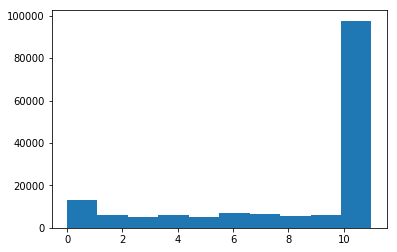

In [56]:
plt.hist(classes,bins=10)

(array([ 13512.,   6159.,   4821.,   6195.,   5425.,   7134.,   6557.,
          5586.,   6118.,  97031.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

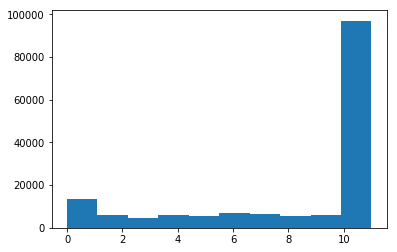

In [65]:
plt.hist(classes,bins=10)

(array([ 14036.,   6387.,   4889.,   6526.,   5729.,   7509.,   6530.,
          5481.,   6817.,  94634.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

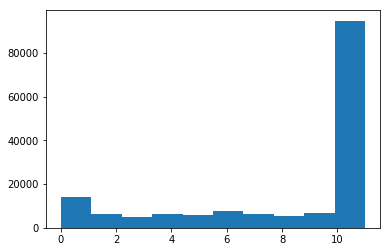

In [57]:
plt.hist(classes,bins=10)

(array([ 12769.,   6288.,   7058.,   6322.,   6488.,   7524.,   5727.,
          6044.,   7517.,  92801.]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

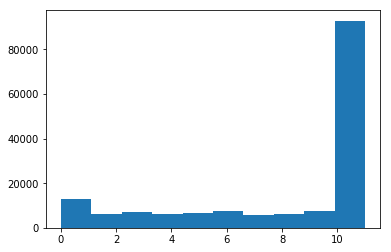

In [411]:
plt.hist(classes,bins=10)

### blending

### submission

In [62]:
### last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [63]:
with open('subm/{}_plus_dilated_convnlstm_timek23_n_freqk8_extrabn.csv'.format(exp_name), 'w') as fout:
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))

In [64]:
from IPython.lib.display import FileLink

FileLink('subm/{}_plus_dilated_convnlstm_timek23_n_freqk8_extrabn.csv'.format(exp_name))


/home/ubuntu/keyword_spotting/subm/aebase_mix_1dtimeconvswithmaxpool_finetune_plus_dilated_convnlstm_timek23_n_freqk8_extrabn.csv